In [1]:
#!{sys.executable} -m pip install salib
#!{sys.executable} -m pip install epimodels
#!{sys.executable} -m pip install seaborn

In [2]:
%display typeset

In [3]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from epimodels.continuous import models as cm
import seaborn as sns
import numpy as np
import pandas as pd
import pylab as plt
from collections import OrderedDict

In [4]:
problem = {
    'num_vars': 5,
    'names' : list(['beta-kkk', 'alpha-kkk', 'T-kkk', 'f-kkk', 'N-kkk']),
    'bounds': [
        [0.01,0.99], #beta
        [0.01,0.99], #alpha
        [1, 1.5], #T
        [0.01,0.99], #f
        [100,200], #N
    ]
}

In [5]:
param_values = saltelli.sample(problem, 100)
param_values.shape

(1200, 5)

In [6]:
params = [1, 1, 1, 1, 1]
def seird(t,y):
    S, E, I, R, D = y
    beta, alpha, T, f, N = params
    return [
        -beta * S * I / N,
        beta * S * I / N - alpha * E,
        alpha * E - 1/T * I,
        (1-f)/T * I,
        f/T*I
    ]

In [7]:

def eval_model(parametros):
    
    #mod = cm.SEIR()
    #mod(inits=inits, trange = [0,200], totpop=1, params=parms)
    
    global params
    params = parametros
    
    T = ode_solver()
    T.algorithm='rk8pd'
    T.function = seird
    y0=[100, 10, 10, 10, 10]
    T.ode_solve(t_span=[0,10],y_0=y0, num_points=10)

    Y = max([k[1][2] for k in T.solution])
    return Y

In [8]:
from multiprocessing import Pool

In [9]:
Po = Pool()
Y = Po.map(eval_model, param_values)

In [10]:
Si = sobol.analyze(problem, np.array(Y), print_to_console=False)

In [11]:
def plot_sobol(si,prob, order=1):
    Si_filter = {k:si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'][:-1)
    fig, ax = plt.subplots(1, figsize=(10,8))

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)

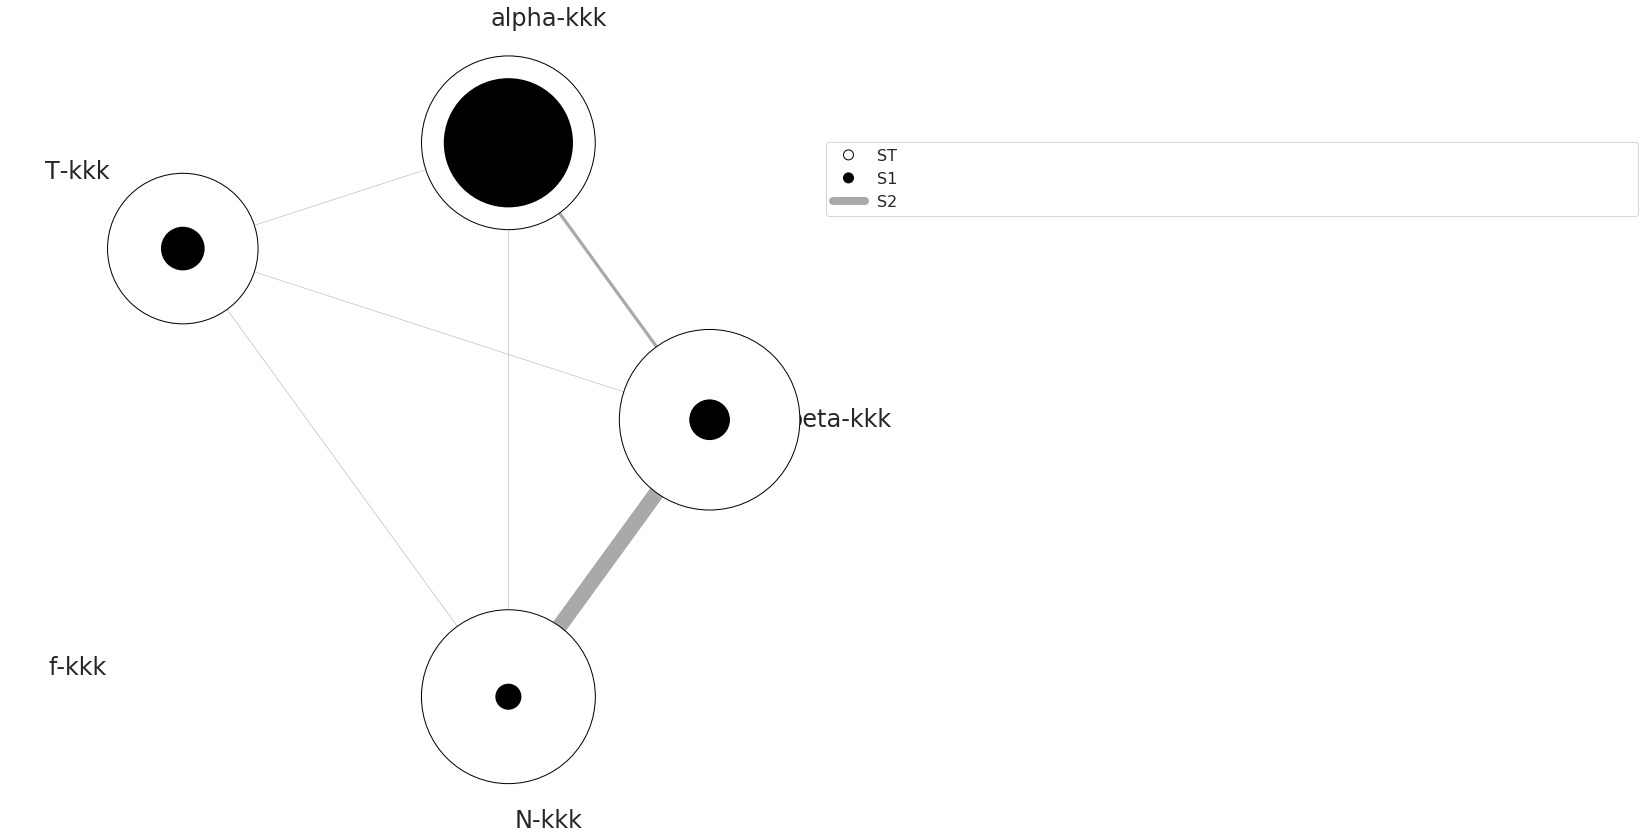

In [15]:


import itertools
from math import pi
from matplotlib.legend_handler import HandlerPatch


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names, fontsize=24)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig



class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand', fontsize=16,
              handler_map={plt.Circle: HandlerCircle()})


sns.set_style('whitegrid')
fig = plot_sobol_indices(Si, criterion='ST', threshold=0.005)

